# DB Connections

In [7]:
import pandas as pd 
import pyodbc
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import math

# Use PIP INSTALL "scikit-learn" to install the library
from sklearn.cluster import KMeans

conn = sqlite3.connect('../data/processed/United_Outdoors.sqlite3')

# Cluster Model Creation

In [8]:
product = pd.read_sql_query('SELECT * FROM Product', conn)
product_inventory = pd.read_sql_query('SELECT * FROM ProductInventory', conn)
merged = pd.merge(product, product_inventory, left_on='ProductID_AW', right_on='ProductID')

df = merged.loc[:, ['ProductID', 'Name_x', 'Quantity']]
df

,ProductID,Name_x,Quantity
0,771,"Mountain-100 Silver, 38",49
1,771,"Mountain-100 Silver, 38",100
2,772,"Mountain-100 Silver, 42",88
3,772,"Mountain-100 Silver, 42",65
4,773,"Mountain-100 Silver, 44",83
...,...,...,...
1064,535,Tension Pulley,427
1065,535,Tension Pulley,409
1066,679,Rear Derailleur Cage,164
1067,679,Rear Derailleur Cage,136


# One-Hot Encoding

In [9]:
dummies = pd.get_dummies(df.loc[:,'Name_x'])
dummies.head()

,AWC Logo Cap,Adjustable Race,All-Purpose Bike Stand,BB Ball Bearing,Bearing Ball,Bike Wash - Dissolver,Blade,Cable Lock,Chain,Chain Stays,...,"Touring-3000 Yellow, 58","Touring-3000 Yellow, 62","Touring-Panniers, Large",Water Bottle - 30 oz.,"Women's Mountain Shorts, L","Women's Mountain Shorts, M","Women's Mountain Shorts, S","Women's Tights, L","Women's Tights, M","Women's Tights, S"
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Combine & Remove

In [10]:
df = pd.concat([df, dummies], axis=1)
df = df.drop(columns=['Name_x'])
df.head()

,ProductID,Quantity,AWC Logo Cap,Adjustable Race,All-Purpose Bike Stand,BB Ball Bearing,Bearing Ball,Bike Wash - Dissolver,Blade,Cable Lock,...,"Touring-3000 Yellow, 58","Touring-3000 Yellow, 62","Touring-Panniers, Large",Water Bottle - 30 oz.,"Women's Mountain Shorts, L","Women's Mountain Shorts, M","Women's Mountain Shorts, S","Women's Tights, L","Women's Tights, M","Women's Tights, S"
0,771,49,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,771,100,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,772,88,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,772,65,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,773,83,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Building Clustering Model 2 Dimensions

In [11]:
df_2d = df[['ProductID', 'Quantity']]
df_2d.head()

,ProductID,Quantity
0,771,49
1,771,100
2,772,88
3,772,65
4,773,83


In [12]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit_predict(df_2d)

array([2, 2, 2, ..., 2, 2, 2])

In [13]:
kmeans_centra = pd.DataFrame(kmeans.cluster_centers_)

for i in range(len(kmeans_centra.columns)):
    kmeans_centra = kmeans_centra.rename(columns = {i : f'{df_2d.columns[i]}'})
    
kmeans_centra

,ProductID,Quantity
0,874.223602,301.906832
1,413.915110,436.487267
2,845.272727,94.909091


In [14]:
for src_index, _ in df_2d.iterrows():
    euclidian_distances = dict()
    print(f"Afstand van bronindex {src_index} tot...")

    for centrumindex, _ in kmeans_centra.iterrows():
        print(f"\tCentrumindex {centrumindex}:")
        euclidian_sum = 0

        for column_name in kmeans_centra.columns:
            current_difference = df_2d.at[src_index, column_name] - kmeans_centra.at[centrumindex, column_name]
            print(f'\t\t{df_2d.at[src_index, column_name]} - {kmeans_centra.at[centrumindex, column_name]} = {current_difference}')
            euclidian_sum += current_difference ** 2
        
        print(f'\tTotale euclidische som: {euclidian_sum}')
        euclidian_distance = math.sqrt(euclidian_sum)
        print(f'\tEuclidische afstand: {euclidian_distance}')
        euclidian_distances[centrumindex] = euclidian_distance
        print('------------------------------------------------')
    
    print(euclidian_distances)
    centrum_number = min(euclidian_distances, key = euclidian_distances.get)
    print(centrum_number)
    df_2d.at[src_index, 'Centrum'] = centrum_number
    print("================================================")

df_2d

Afstand van bronindex 0 tot...
	Centrumindex 0:
		771 - 874.2236024844718 = -103.22360248447183
		49 - 301.90683229813664 = -252.90683229813664
	Totale euclidische som: 74616.97793295007
	Euclidische afstand: 273.1610842212889
------------------------------------------------
	Centrumindex 1:
		771 - 413.91511035653656 = 357.08488964346344
		49 - 436.48726655348054 = -387.48726655348054
	Totale euclidische som: 277656.0001527725
	Euclidische afstand: 526.9307356311383
------------------------------------------------
	Centrumindex 2:
		771 - 845.272727272727 = -74.27272727272702
		49 - 94.90909090909102 = -45.90909090909102
	Totale euclidische som: 7624.082644628072
	Euclidische afstand: 87.31599306328751
------------------------------------------------
{0: 273.1610842212889, 1: 526.9307356311383, 2: 87.31599306328751}
2
Afstand van bronindex 1 tot...
	Centrumindex 0:
		771 - 874.2236024844718 = -103.22360248447183
		100 - 301.90683229813664 = -201.90683229813664
	Totale euclidische som:

C:\Users\Noah\AppData\Local\Temp\ipykernel_232992\3398783965.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2d.at[src_index, 'Centrum'] = centrum_number


,ProductID,Quantity,Centrum
0,771,49,2.0
1,771,100,2.0
2,772,88,2.0
3,772,65,2.0
4,773,83,2.0
...,...,...,...
1064,535,427,1.0
1065,535,409,1.0
1066,679,164,2.0
1067,679,136,2.0



For k=2:
Inter-cluster distance between cluster 0 and cluster 1: 518.3793112872413
Average intra-cluster distance for cluster 0: 138.68197463262047
Average intra-cluster distance for cluster 1: 151.3682319190782


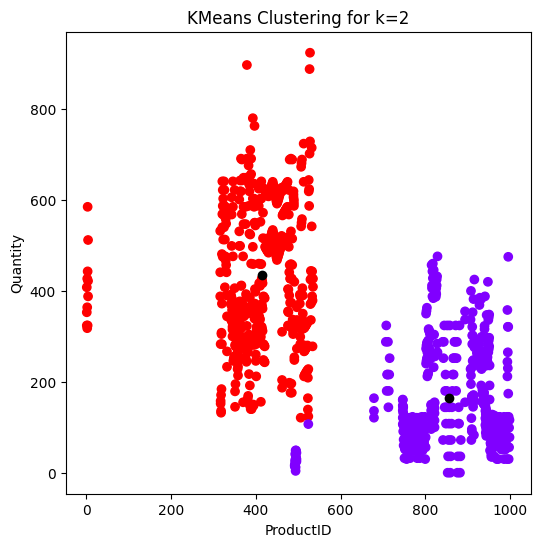


For k=3:
Inter-cluster distance between cluster 0 and cluster 1: 479.57981734999066
Inter-cluster distance between cluster 0 and cluster 2: 209.02205174500668
Inter-cluster distance between cluster 1 and cluster 2: 550.2236306704433
Average intra-cluster distance for cluster 0: 86.62751288153775
Average intra-cluster distance for cluster 1: 151.05715303637615
Average intra-cluster distance for cluster 2: 111.85932044981656


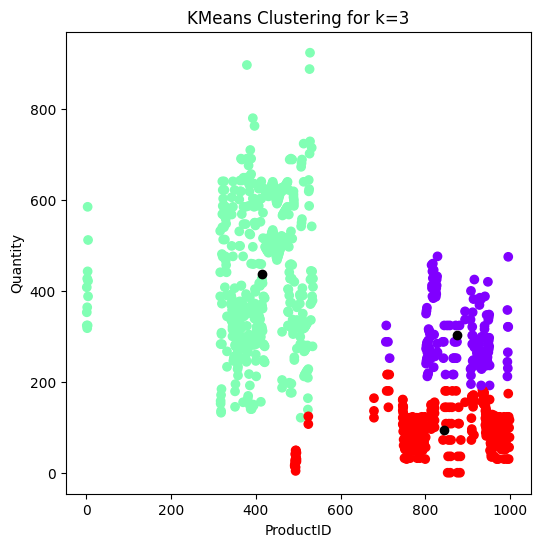


For k=4:
Inter-cluster distance between cluster 0 and cluster 1: 513.1859884276478
Inter-cluster distance between cluster 0 and cluster 2: 204.47785176237477
Inter-cluster distance between cluster 0 and cluster 3: 464.4924470112816
Inter-cluster distance between cluster 1 and cluster 2: 638.6516405953699
Inter-cluster distance between cluster 1 and cluster 3: 272.59694422537746
Inter-cluster distance between cluster 2 and cluster 3: 498.9973056693065
Average intra-cluster distance for cluster 0: 87.76849197533853
Average intra-cluster distance for cluster 1: 86.97525143133916
Average intra-cluster distance for cluster 2: 97.2930047225288
Average intra-cluster distance for cluster 3: 108.2377514192964


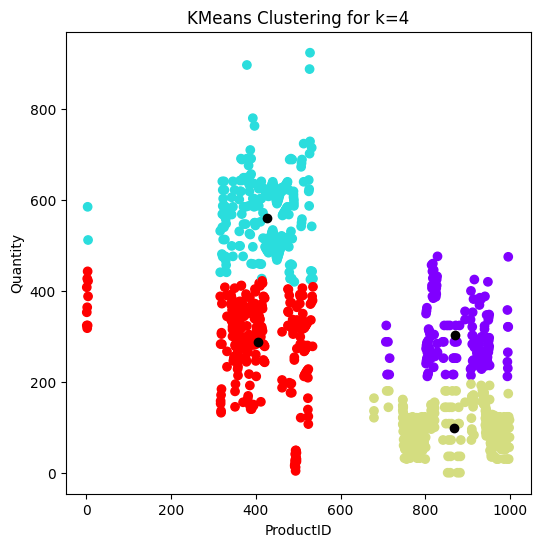


For k=5:
Inter-cluster distance between cluster 0 and cluster 1: 515.7527415914351
Inter-cluster distance between cluster 0 and cluster 2: 204.47785176237477
Inter-cluster distance between cluster 0 and cluster 3: 433.88231928910454
Inter-cluster distance between cluster 0 and cluster 4: 483.78972782833085
Inter-cluster distance between cluster 1 and cluster 2: 642.8469610803023
Inter-cluster distance between cluster 1 and cluster 3: 396.12540632931496
Inter-cluster distance between cluster 1 and cluster 4: 229.50914724311602
Inter-cluster distance between cluster 2 and cluster 3: 417.30549218636514
Inter-cluster distance between cluster 2 and cluster 4: 537.2318402559154
Inter-cluster distance between cluster 3 and cluster 4: 182.3309910183888
Average intra-cluster distance for cluster 0: 87.76849197533853
Average intra-cluster distance for cluster 1: 82.71160829783928
Average intra-cluster distance for cluster 2: 97.2930047225288
Average intra-cluster distance for cluster 3: 99.0019

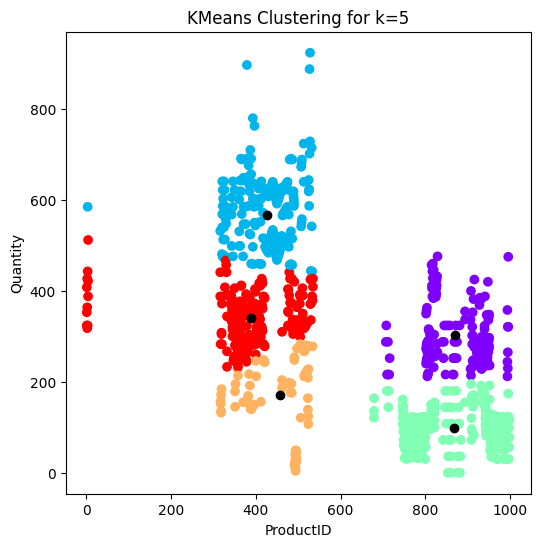


For k=6:
Inter-cluster distance between cluster 0 and cluster 1: 515.6168927638448
Inter-cluster distance between cluster 0 and cluster 2: 228.9651756975027
Inter-cluster distance between cluster 0 and cluster 3: 436.08034591128455
Inter-cluster distance between cluster 0 and cluster 4: 485.0248422543997
Inter-cluster distance between cluster 0 and cluster 5: 216.83177971219087
Inter-cluster distance between cluster 1 and cluster 2: 589.0062766156593
Inter-cluster distance between cluster 1 and cluster 3: 396.12540632931496
Inter-cluster distance between cluster 1 and cluster 4: 229.50914724311602
Inter-cluster distance between cluster 1 and cluster 5: 700.9605721904466
Inter-cluster distance between cluster 2 and cluster 3: 332.7039556283594
Inter-cluster distance between cluster 2 and cluster 4: 462.7993516108545
Inter-cluster distance between cluster 2 and cluster 5: 174.50010620094326
Inter-cluster distance between cluster 3 and cluster 4: 182.3309910183888
Inter-cluster distance 

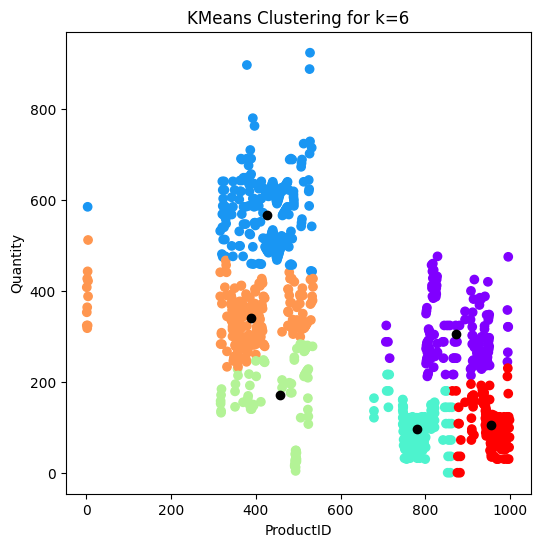


For k=7:
Inter-cluster distance between cluster 0 and cluster 1: 515.0674904459611
Inter-cluster distance between cluster 0 and cluster 2: 228.9651756975027
Inter-cluster distance between cluster 0 and cluster 3: 453.1488016808448
Inter-cluster distance between cluster 0 and cluster 4: 458.0037006605623
Inter-cluster distance between cluster 0 and cluster 5: 216.83177971219087
Inter-cluster distance between cluster 0 and cluster 6: 874.9029433585766
Inter-cluster distance between cluster 1 and cluster 2: 588.4632546455101
Inter-cluster distance between cluster 1 and cluster 3: 424.0305632336406
Inter-cluster distance between cluster 1 and cluster 4: 235.2639286164915
Inter-cluster distance between cluster 1 and cluster 5: 700.4033162558137
Inter-cluster distance between cluster 1 and cluster 6: 454.83725250070484
Inter-cluster distance between cluster 2 and cluster 3: 335.1339408461512
Inter-cluster distance between cluster 2 and cluster 4: 435.5473872933115
Inter-cluster distance bet

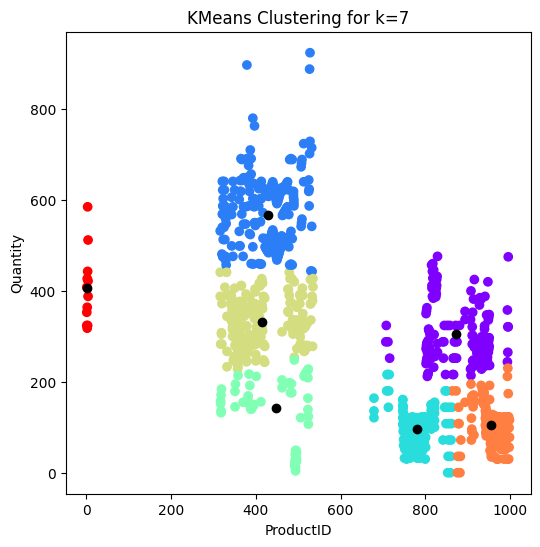


For k=8:
Inter-cluster distance between cluster 0 and cluster 1: 569.2605714035001
Inter-cluster distance between cluster 0 and cluster 2: 473.55854327443967
Inter-cluster distance between cluster 0 and cluster 3: 264.07886913235296
Inter-cluster distance between cluster 0 and cluster 4: 113.15541885914031
Inter-cluster distance between cluster 0 and cluster 5: 531.3867421499547
Inter-cluster distance between cluster 0 and cluster 6: 226.46974849554633
Inter-cluster distance between cluster 0 and cluster 7: 494.1625989402165
Inter-cluster distance between cluster 1 and cluster 2: 455.92424009743115
Inter-cluster distance between cluster 1 and cluster 3: 641.9848273673175
Inter-cluster distance between cluster 1 and cluster 4: 531.01084578215
Inter-cluster distance between cluster 1 and cluster 5: 300.62831485653254
Inter-cluster distance between cluster 1 and cluster 6: 745.5120547915212
Inter-cluster distance between cluster 1 and cluster 7: 140.5486073940847
Inter-cluster distance b

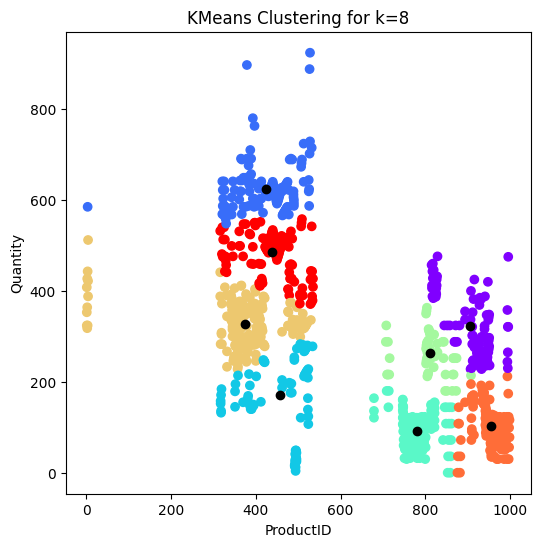

In [15]:
from sklearn.cluster import KMeans
import numpy as np

# Range of k values to try
k_values = range(2, 9)

for k in k_values:
    # Fit the KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_2d)
    
    # Calculate and print inter-cluster distances
    print(f"\nFor k={k}:")
    for i in range(k):
        for j in range(i+1, k):
            diff = kmeans.cluster_centers_[i] - kmeans.cluster_centers_[j]
            dist = np.sqrt(np.sum(diff**2))
            print(f"Inter-cluster distance between cluster {i} and cluster {j}: {dist}")
    
    # Calculate and print intra-cluster distances
    for i in range(k):
        cluster_points = df_2d[kmeans.labels_ == i]
        distances = np.sqrt(np.sum((cluster_points - kmeans.cluster_centers_[i])**2, axis=1))
        avg_distance = np.mean(distances)
        print(f"Average intra-cluster distance for cluster {i}: {avg_distance}")

    # Plot the clusters
    plt.figure(figsize=(6, 6))
    plt.scatter(df_2d['ProductID'], df_2d['Quantity'], c=kmeans.labels_, cmap='rainbow')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='black')
    plt.xlabel('ProductID')
    plt.ylabel('Quantity')
    plt.title(f'KMeans Clustering for k={k}')
    plt.show()

# Scatter Map

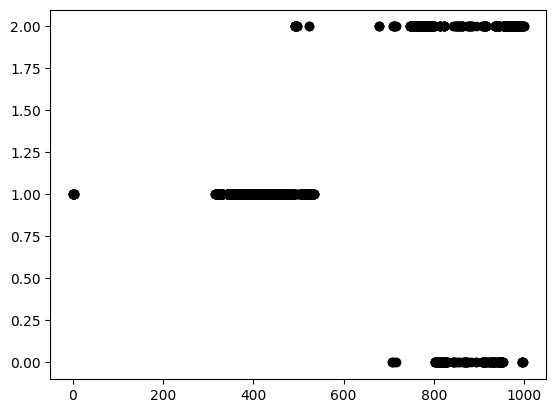

In [16]:
plt.scatter(df_2d['ProductID'], df_2d['Centrum'], color = 'k')
plt.show()

In [17]:
df_2d.groupby('Centrum', as_index=False)['Centrum'].count()

,Centrum
0,161
1,589
2,319


# Cluster Model With 3+ Dimesions

In [18]:
kmeans = KMeans(n_clusters = 6, random_state = 42)
prediction_results = kmeans.fit_predict(df)
prediction_results

array([2, 2, 2, ..., 2, 2, 2])

In [19]:
df['Cluster'] = prediction_results
df.head()

,ProductID,Quantity,AWC Logo Cap,Adjustable Race,All-Purpose Bike Stand,BB Ball Bearing,Bearing Ball,Bike Wash - Dissolver,Blade,Cable Lock,...,"Touring-3000 Yellow, 62","Touring-Panniers, Large",Water Bottle - 30 oz.,"Women's Mountain Shorts, L","Women's Mountain Shorts, M","Women's Mountain Shorts, S","Women's Tights, L","Women's Tights, M","Women's Tights, S",Cluster
0,771,49,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
1,771,100,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
2,772,88,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
3,772,65,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
4,773,83,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2


In [20]:
df.groupby('Cluster', as_index = False)['Cluster'].count()

,Cluster
0,156
1,289
2,155
3,84
4,233
5,152


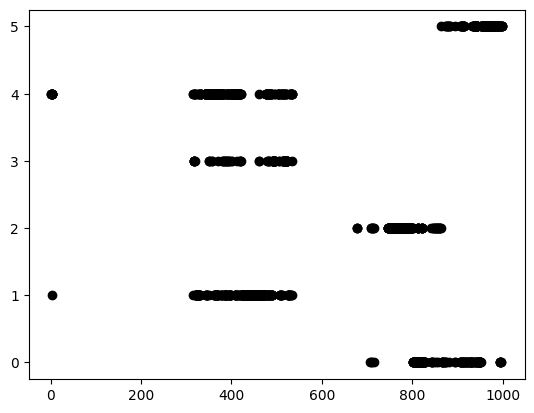

In [21]:
plt.scatter(df['ProductID'], df['Cluster'], color = 'k')
plt.show()